In [103]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import tqdm
from tqdm import trange

sys.path.insert(1, '/Users/nickkeesey/Desktop/learning-dynamics-behavior/src/utils')
import behavior_utils as bu

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


##### 

In [123]:
df_original = pd.read_csv('/Users/nickkeesey/Desktop/learning-dynamics-behavior/data/comparison_bonsai_df.csv')

df_original.sort_values(by='subject_id', inplace=True)

df_original

,subject_id,session_date,nwb_suffix,session,rig,user_name,curriculum_name,curriculum_version,current_stage_actual,task,...,data_source,abs(bias_naive),abs(logistic_Su2022_bias),abs(logistic_Bari2019_bias),abs(logistic_Hattori2019_bias),abs(logistic_Miller2021_bias),weekday,avg_trial_length_in_seconds,water_day_total_last_session,water_after_session_last_session
6169,662914,2023-09-19,0,1.0,Blue-1,Katrina Nguyen,NaN,NaN,NaN,Uncoupled Without Baiting,...,AIND_training_447_bonsai,0.041885,0.050190,0.063603,0.063459,0.343473,2,8.112245,1.000,0.200
6093,662914,2023-10-06,0,9.0,Green-2,Ella Hilton,NaN,NaN,NaN,Uncoupled Without Baiting,...,AIND_training_447_bonsai,0.671687,0.545351,0.409615,0.415166,0.329638,5,7.713004,NaN,NaN
6164,662914,2023-09-21,0,2.0,Blue-1,Katrina Nguyen,NaN,NaN,NaN,Uncoupled Without Baiting,...,AIND_training_447_bonsai,0.049645,0.255776,0.194388,0.254168,0.029090,4,7.659574,1.000,0.000
6131,662914,2023-09-29,0,5.0,Blue-1,Katrina Nguyen,NaN,NaN,NaN,Uncoupled Without Baiting,...,AIND_training_447_bonsai,0.382609,0.556757,0.359746,0.382169,0.354122,5,7.681366,1.340,0.221
6125,662914,2023-10-03,1,6.0,Green-2,Ella Hilton,NaN,NaN,NaN,Uncoupled Without Baiting,...,AIND_training_447_bonsai,0.072165,0.110015,0.071359,0.067324,0.012978,2,7.917889,1.000,0.103
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,776296,2025-01-06,122357,1.0,447-3-C,Avalon Amaya,Uncoupled Baiting,2.3,STAGE_1_WARMUP,Coupled Baiting,...,AIND_training_447_bonsai,0.058824,0.020272,0.005877,0.021927,0.021165,1,6.890459,1.632,0.890
47,776296,2025-01-08,132251,3.0,447-3-C,Avalon Amaya,Uncoupled Baiting,2.3,STAGE_2,Coupled Baiting,...,AIND_training_447_bonsai,0.024024,0.067681,0.059504,0.032865,0.052103,3,6.224066,1.513,0.990
15,776296,2025-01-10,131550,5.0,447-3-C,Avalon Amaya,Uncoupled Baiting,2.3,STAGE_FINAL,Uncoupled Baiting,...,AIND_training_447_bonsai,0.281106,0.201647,0.166458,0.162098,0.172733,5,10.344828,NaN,NaN
65,776296,2025-01-07,121657,2.0,447-3-C,Avalon Amaya,Uncoupled Baiting,2.3,STAGE_2,Coupled Baiting,...,AIND_training_447_bonsai,0.190332,0.377489,0.278989,0.296081,0.276343,2,6.484150,1.711,0.920


In [124]:
def calculate_session_proportion(df):
    """
    Calculate session proportion for each subject by dividing current session number 
    by total number of sessions for that subject.
    
    Args:
    df : pd.DataFrame
        DataFrame containing 'subject_id' and 'session' columns
        
    Returns
    pd.DataFrame
        Input DataFrame with new 'session_proportion' column added
    """
    # Get unique subjects
    subjects = df['subject_id'].unique()
    
    # For each subject
    for subject in subjects:
        # Get total sessions for this subject
        subject_df = df[df['subject_id'] == subject]
        total_sessions = len(subject_df)
        
        # Calculate proportion and assign to new column
        mask = df['subject_id'] == subject
        df.loc[mask, 'session_proportion'] = \
            df.loc[mask, 'session'] / total_sessions
        
        # Create classifications based on session proportion for each subject
        subject_proportions = df.loc[mask, 'session_proportion']
        df.loc[mask, 'session_proportion_class'] = pd.cut(
            subject_proportions,
            bins = [float('-inf'), 0.33, 0.66, float('inf')],
            labels = [0, 1, 2]
        )

    return df

df = calculate_session_proportion(df_original)

df


,subject_id,session_date,nwb_suffix,session,rig,user_name,curriculum_name,curriculum_version,current_stage_actual,task,...,abs(logistic_Su2022_bias),abs(logistic_Bari2019_bias),abs(logistic_Hattori2019_bias),abs(logistic_Miller2021_bias),weekday,avg_trial_length_in_seconds,water_day_total_last_session,water_after_session_last_session,session_proportion,session_proportion_class
6169,662914,2023-09-19,0,1.0,Blue-1,Katrina Nguyen,NaN,NaN,NaN,Uncoupled Without Baiting,...,0.050190,0.063603,0.063459,0.343473,2,8.112245,1.000,0.200,0.111111,0
6093,662914,2023-10-06,0,9.0,Green-2,Ella Hilton,NaN,NaN,NaN,Uncoupled Without Baiting,...,0.545351,0.409615,0.415166,0.329638,5,7.713004,NaN,NaN,1.000000,2
6164,662914,2023-09-21,0,2.0,Blue-1,Katrina Nguyen,NaN,NaN,NaN,Uncoupled Without Baiting,...,0.255776,0.194388,0.254168,0.029090,4,7.659574,1.000,0.000,0.222222,0
6131,662914,2023-09-29,0,5.0,Blue-1,Katrina Nguyen,NaN,NaN,NaN,Uncoupled Without Baiting,...,0.556757,0.359746,0.382169,0.354122,5,7.681366,1.340,0.221,0.555556,1
6125,662914,2023-10-03,1,6.0,Green-2,Ella Hilton,NaN,NaN,NaN,Uncoupled Without Baiting,...,0.110015,0.071359,0.067324,0.012978,2,7.917889,1.000,0.103,0.666667,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,776296,2025-01-06,122357,1.0,447-3-C,Avalon Amaya,Uncoupled Baiting,2.3,STAGE_1_WARMUP,Coupled Baiting,...,0.020272,0.005877,0.021927,0.021165,1,6.890459,1.632,0.890,0.200000,0
47,776296,2025-01-08,132251,3.0,447-3-C,Avalon Amaya,Uncoupled Baiting,2.3,STAGE_2,Coupled Baiting,...,0.067681,0.059504,0.032865,0.052103,3,6.224066,1.513,0.990,0.600000,1
15,776296,2025-01-10,131550,5.0,447-3-C,Avalon Amaya,Uncoupled Baiting,2.3,STAGE_FINAL,Uncoupled Baiting,...,0.201647,0.166458,0.162098,0.172733,5,10.344828,NaN,NaN,1.000000,2
65,776296,2025-01-07,121657,2.0,447-3-C,Avalon Amaya,Uncoupled Baiting,2.3,STAGE_2,Coupled Baiting,...,0.377489,0.278989,0.296081,0.276343,2,6.484150,1.711,0.920,0.400000,1


In [125]:
df_original.columns.tolist()

['subject_id',
 'session_date',
 'nwb_suffix',
 'session',
 'rig',
 'user_name',
 'curriculum_name',
 'curriculum_version',
 'current_stage_actual',
 'task',
 'notes',
 'experiment_description',
 'session_start_time',
 'session_end_time',
 'session_run_time_in_min',
 'water_in_session_foraging',
 'water_in_session_manual',
 'water_in_session_total',
 'water_after_session',
 'water_day_total',
 'base_weight',
 'target_weight',
 'target_weight_ratio',
 'weight_after',
 'laser_1_calibration_power',
 'laser_2_calibration_power',
 'laser_1_target_areas',
 'laser_2_target_areas',
 'commit_ID',
 'repo_url',
 'current_branch',
 'weight_after_ratio',
 'p_reward_sum_mean',
 'p_reward_sum_std',
 'p_reward_sum_median',
 'p_reward_contrast_mean',
 'p_reware_contrast_median',
 'effective_block_length_mean',
 'effective_block_length_std',
 'effective_block_length_median',
 'effective_block_length_min',
 'effective_block_length_max',
 'duration_gocue_stop_mean',
 'duration_gocue_stop_std',
 'duration_

In [126]:
def clean_numeric_features(df, cols, nan_strategy='knn', target_col='session_proportion', min_samples = 2,  knn_neighbors=5, add_indicator=False):
    """
    Clean numeric features by imputing missing values using KNNImputer
    
    Args:
        df: pd.DataFrame
            Input DataFrame
        cols: list
            List of columns to clean
        nan_strategy: str
            Strategy for imputing missing values
        min_samples: int
            Minimum number of samples in each neighborhood for KNNImputer
        knn_neighbors: int
            Number of neighbors to use for KNNImputer
        add_indicator: bool
            If True, add indicator columns for missing values
            
    Returns:
        pd.DataFrame
            DataFrame with cleaned numeric features
    """

    # Create a copy of the dataframe
    df_clean = df.copy()

    # Remove target samples under threshold
    class_counts = df_clean[target_col].value_counts()
    valid_classes = class_counts[class_counts >= min_samples].index
    df_clean = df_clean[df_clean[target_col].isin(valid_classes).copy()]

    new_columns = []

    # Handle infinite values
    for col in cols:
        df_clean.loc[:, col] = df_clean[col].replace([np.inf, -np.inf], np.nan)

    if add_indicator:
        for col in cols:
            if df_clean[col].isna().any():
                indicator_col = f'{col}_is_missing'
                df_clean.loc[:, indicator_col] = df_clean[col].isna().astype(int)
                new_columns.append(indicator_col)

    # drop strat
    if nan_strategy == 'drop':
        df_clean = df_clean.dropna(subset=cols)
    
    # knn strat
    elif nan_strategy == 'knn':
        imputer = KNNImputer(n_neighbors=knn_neighbors)
        df_clean[cols] = imputer.fit_transform(df_clean[cols])

    # median strat
    elif nan_strategy == 'median' or nan_strategy == 'indicator':
        for col in cols:
            median_val = df_clean[col].median()
            df_clean[col] = df_clean[col].fillna(median_val)

    # Handle extreme values after imputation
    for col in cols:
        Q1 = df_clean[col].quantile(0.01)
        Q3 = df_clean[col].quantile(0.99)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df_clean[col] = df_clean[col].clip(lower_bound, upper_bound)
        
    return df_clean, new_columns

In [127]:
feature_cols = [
                'ignore_rate', 'reward_rate', 'finished_rate', 'double_dipping_rate_finished_trials',
                'double_dipping_rate_finished_reward_trials',
                'double_dipping_rate_finished_noreward_trials',
                'lick_consistency_mean_finished_trials',
                'lick_consistency_mean_finished_reward_trials',
                'lick_consistency_mean_finished_noreward_trials',
                'foraging_performance', 'foraging_eff',
                'early_lick_rate', 
                'invalid_lick_ratio', 'double_dipping_rate_finished_trials', 
                'lick_consistency_mean_finished_trials','reaction_time_mean'
                ]

cat_cols = ['task']

target_col = 'session_proportion_class'

In [128]:
clean_df, _ = clean_numeric_features(df_original, 
                                  cols = feature_cols, 
                                  nan_strategy='knn'
                                  )
clean_df

,subject_id,session_date,nwb_suffix,session,rig,user_name,curriculum_name,curriculum_version,current_stage_actual,task,...,abs(logistic_Su2022_bias),abs(logistic_Bari2019_bias),abs(logistic_Hattori2019_bias),abs(logistic_Miller2021_bias),weekday,avg_trial_length_in_seconds,water_day_total_last_session,water_after_session_last_session,session_proportion,session_proportion_class
6169,662914,2023-09-19,0,1.0,Blue-1,Katrina Nguyen,NaN,NaN,NaN,Uncoupled Without Baiting,...,0.050190,0.063603,0.063459,0.343473,2,8.112245,1.000,0.200,0.111111,0
6093,662914,2023-10-06,0,9.0,Green-2,Ella Hilton,NaN,NaN,NaN,Uncoupled Without Baiting,...,0.545351,0.409615,0.415166,0.329638,5,7.713004,NaN,NaN,1.000000,2
6164,662914,2023-09-21,0,2.0,Blue-1,Katrina Nguyen,NaN,NaN,NaN,Uncoupled Without Baiting,...,0.255776,0.194388,0.254168,0.029090,4,7.659574,1.000,0.000,0.222222,0
6131,662914,2023-09-29,0,5.0,Blue-1,Katrina Nguyen,NaN,NaN,NaN,Uncoupled Without Baiting,...,0.556757,0.359746,0.382169,0.354122,5,7.681366,1.340,0.221,0.555556,1
6125,662914,2023-10-03,1,6.0,Green-2,Ella Hilton,NaN,NaN,NaN,Uncoupled Without Baiting,...,0.110015,0.071359,0.067324,0.012978,2,7.917889,1.000,0.103,0.666667,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,776296,2025-01-06,122357,1.0,447-3-C,Avalon Amaya,Uncoupled Baiting,2.3,STAGE_1_WARMUP,Coupled Baiting,...,0.020272,0.005877,0.021927,0.021165,1,6.890459,1.632,0.890,0.200000,0
47,776296,2025-01-08,132251,3.0,447-3-C,Avalon Amaya,Uncoupled Baiting,2.3,STAGE_2,Coupled Baiting,...,0.067681,0.059504,0.032865,0.052103,3,6.224066,1.513,0.990,0.600000,1
15,776296,2025-01-10,131550,5.0,447-3-C,Avalon Amaya,Uncoupled Baiting,2.3,STAGE_FINAL,Uncoupled Baiting,...,0.201647,0.166458,0.162098,0.172733,5,10.344828,NaN,NaN,1.000000,2
65,776296,2025-01-07,121657,2.0,447-3-C,Avalon Amaya,Uncoupled Baiting,2.3,STAGE_2,Coupled Baiting,...,0.377489,0.278989,0.296081,0.276343,2,6.484150,1.711,0.920,0.400000,1


In [129]:
def preprocess_data(df, feature_cols, cat_cols, target_col, test_size = 0.2, random_state = 42):
    """
    Preprocess data for machine basic neural network classification model

    Args: 
    df : pd.DataFrame
        Input df with features and targets
    feature_cols : list
        Names of numerical features
    cat_cols : list
        Names of categorical columns to encode
    target_col : str
        Name of target column to classify in output layer
    test_size: float
        Proportion of data to use for testing

    Returns:
    dict:
        X_train, X_test : preprocessed feature 
        y_train, y_test : encoded target variables
        encoders : dict of fitted LabelEncoders for each categorical feature
        scaler : fitted StandardScaler for numerical features
    """

    df_copy = df.copy()

    # Initialize encoders and scaler
    encoders = {}
    scaler = StandardScaler()
    
    # Categorical column handling 
    encoded_cats = []
    for col in cat_cols:
        if col != target_col:
            encoders[col] = LabelEncoder()
            df_copy[f'{col}_encoded'] = encoders[col].fit_transform(df_copy[col])
            encoded_cats.append(f'{col}_encoded')
    
    # Combine categorical and numerical features
    final_features = feature_cols + encoded_cats
    
    # Scale numerical features
    X = df_copy[final_features].copy()
    X_scaled = scaler.fit_transform(X)
    X_scaled = pd.DataFrame(X_scaled, columns=final_features)

    # Encode target variable
    target_encoder = LabelEncoder()
    y = target_encoder.fit_transform(df_copy[target_col])
    encoders['target'] = target_encoder

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y,
        test_size = test_size,
        random_state = random_state,
        stratify = y
    )

    return {
        'X_train': X_train,
        'X_test': X_test,
        'y_train': y_train, 
        'y_test': y_test,
        'encoders': encoders,
        'scaler': scaler
    }

In [130]:


processed_df = preprocess_data(
    df = clean_df,
    feature_cols = feature_cols,
    cat_cols = cat_cols,
    target_col = target_col
)

print(processed_df['X_train'].shape, processed_df['y_train'].shape)


(4712, 17) (4712,)


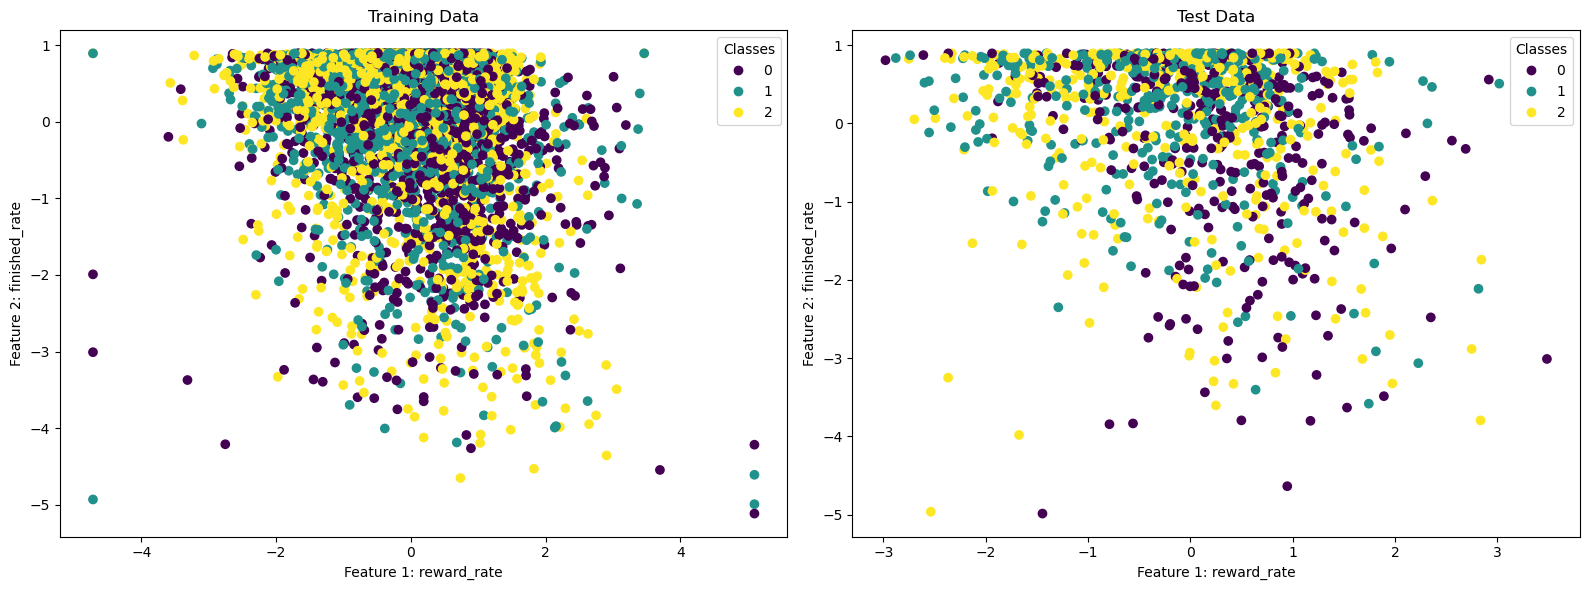

In [131]:
# Visualize dataset before training

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Get first two features for visualization
X_train_2d = processed_df['X_train'].iloc[:, :3]
X_test_2d = processed_df['X_test'].iloc[:, :3]

# Training data scatter plot
scatter1 = ax1.scatter(X_train_2d.iloc[:, 1], X_train_2d.iloc[:, 2], 
                      c=processed_df['y_train'], cmap='viridis')
ax1.set_title('Training Data')
ax1.set_xlabel(f'Feature 1: {processed_df["X_train"].columns[1]}')
ax1.set_ylabel(f'Feature 2: {processed_df["X_train"].columns[2]}')
ax1.legend(*scatter1.legend_elements(), title="Classes")

# Test data scatter plot  
scatter2 = ax2.scatter(X_test_2d.iloc[:, 1], X_test_2d.iloc[:, 2],
                      c=processed_df['y_test'], cmap='viridis')
ax2.set_title('Test Data')
ax2.set_xlabel(f'Feature 1: {processed_df["X_test"].columns[1]}')
ax2.set_ylabel(f'Feature 2: {processed_df["X_test"].columns[2]}')
ax2.legend(*scatter2.legend_elements(), title="Classes")

plt.tight_layout()


##### Define model

In [132]:
class BasicForagingClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim): # initialize input, hidden, and output dimensions

        super(BasicForagingClassifier, self).__init__() # initialize all functions from class

        self.layer1 = nn.Linear(input_dim, hidden_dim) # first layer
        self.layer2 = nn.Linear(hidden_dim, output_dim) # second layer

    def forward(self, x): # forward propagation

        x = torch.relu(self.layer1(x)) # define activation function for layer 1
        x = self.layer2(x) # define layer 2
        
        return x

In [133]:
# Define hyperparameters

model = BasicForagingClassifier(input_dim = 17, hidden_dim = 500, output_dim=3)

learning_rate = 0.01
epochs = 10000

loss_func = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = learning_rate)

In [134]:
# Follow model performance per epoch

train_loss_list = []


##### Train model

In [135]:
# Convert DataFrame/Series to numpy arrays before converting to torch tensors
X_train = torch.from_numpy(processed_df['X_train'].to_numpy()).float()
y_train = torch.from_numpy(processed_df['y_train']).long()

y_train = F.one_hot(y_train, num_classes=3).float()  # Convert to float for MSE loss

for epoch in tqdm.trange(epochs):
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = loss_func(outputs, y_train)

    loss.backward()
    optimizer.step()
    train_loss_list.append(loss.item())

100%|██████████| 10000/10000 [01:02<00:00, 159.02it/s]


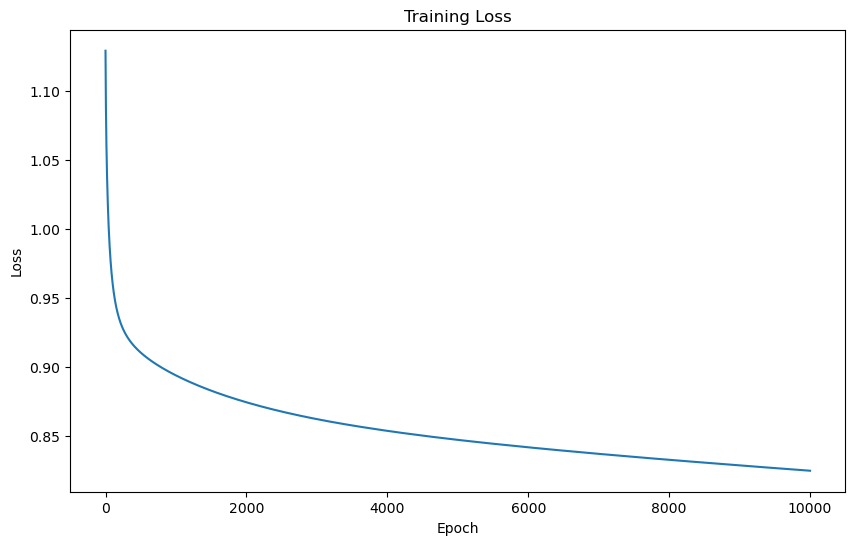

In [136]:
# Visualize and evaluate model performance

plt.figure(figsize=(10, 6))

plt.plot(range(epochs), train_loss_list)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

In [137]:
# Convert test data to tensors
X_test = torch.from_numpy(processed_df['X_test'].to_numpy()).float()
y_test = torch.from_numpy(processed_df['y_test']).long()

# Get model predictions
model.eval()
with torch.no_grad():
    test_outputs = model(X_test)
    predicted_classes = torch.argmax(test_outputs, dim=1)
    
# Calculate accuracy
correct = (predicted_classes == y_test).sum().item()
total = y_test.size(0)
accuracy = correct / total

print(f'Test Accuracy: {accuracy:.4f}')


Test Accuracy: 0.5942
